In [1]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import layers
import tensorflow as tf

from IPython import display

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data ()

In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

In [4]:
#
# We're only going to learn how to generate 1 digit.  
# This saves time and makes it easier for smaller computers.
#

MaxExamples = 7000
targetDigit = 7          # The digit that we are going to learn to draw (generate)

targetIm = np.empty ([MaxExamples, 28, 28, 1])

total = 0
for i in range (60000):
    if train_labels[i] != targetDigit:
        continue

    x = train_images[i]
    x = tf.reshape (x, [1, 28, 28, 1])
    targetIm[total] = x[0]
    total = total + 1



2023-12-20 15:15:33.159058: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-20 15:15:33.159149: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [5]:
# Reshape to ensure that all entries are valid
targetIm = targetIm[0:total]

tf.shape (targetIm)

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([6265,   28,   28,    1], dtype=int32)>

In [6]:
#
# Values are [0, 255], so normalize the images to [-1, 1]
#

targetIm = (targetIm - 127.5) / 127.5  

In [7]:
GROUND_TRUTH_SIZE = total  # The number of examples of the target digit that we found
BATCH_SIZE = 256           # Number of examples to use per update.  Smaller means faster epochs.

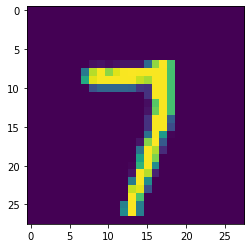

In [8]:
plt.imshow (targetIm[4000]) # Correct digit?

In [9]:
#
# Shuffle the data and construct batches
#

train_dataset = tf.data.Dataset.from_tensor_slices (targetIm).shuffle (GROUND_TRUTH_SIZE).batch (BATCH_SIZE)


In [10]:
noiseVecDim = 100 

# 
# A returned model is a mapping: noiseVecDim x 1 --> 28 x 28
#
# Note that 28x28=784 > 100.  The input dimensions are not the most important thing: it is the learned
# transformation in the form of the tranpose convolutions (their learnable parameters).
#
#

def BuildForger ():
    
    model = tf.keras.Sequential ()

    model.add (layers.Dense(7*7*256, use_bias=False, activation="relu", input_shape=(noiseVecDim,)))
    model.add (layers.BatchNormalization())

    model.add (layers.Reshape((14, 14, 64)))

    model.add (layers.Conv2DTranspose (128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add (layers.BatchNormalization())
    model.add (layers.LeakyReLU())

    model.add (layers.Conv2DTranspose (64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add (layers.BatchNormalization())
    model.add (layers.LeakyReLU())

    model.add (layers.Conv2DTranspose(1, (2, 2), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [11]:
G = BuildForger ()  # Build forger

G.output_shape

(None, 28, 28, 1)

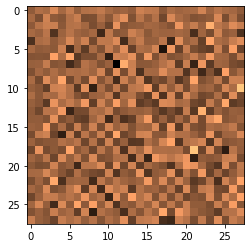

In [12]:
noise = tf.random.normal ([1, noiseVecDim])

fake = G (noise, training=False)

plt.imshow (fake[0], cmap='copper') # currently just the expected random noise

In [13]:
#
# This return a model that acts as a gatekeeper.  It is not very different from
# the MNIST classifers in the other notebooks.
#

def BuildAppraiser ():
    
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), 
                            strides=(1, 1), 
                            padding='same',
                            input_shape=[28, 28, 1]))

    model.add (layers.Conv2D (128, (5, 5), strides=(2, 2), padding='same'))
    model.add (layers.LeakyReLU())

    model.add (layers.Flatten())
    model.add (layers.Dense(75, activation="relu"))
    model.add (layers.Dense(75, activation="relu"))
    model.add (layers.Dense(1))

    return model


In [14]:
D = BuildAppraiser ()
decision = D (fake)

print (decision)

tf.Tensor([[-0.00588027]], shape=(1, 1), dtype=float32)


In [15]:
MLE = tf.keras.losses.BinaryCrossentropy (from_logits=True)

In [16]:
def D_loss (real_output, fake_output):
    
    real_loss = MLE (tf.ones_like(real_output), real_output)   # 1 when D accepts an image
    fake_loss = MLE (tf.zeros_like(fake_output), fake_output)  # 0 when D detects a fake
    total_loss = real_loss + fake_loss
    
    return total_loss

In [17]:
def G_loss (fake_output):
    return MLE (tf.ones_like(fake_output), fake_output)        # We want a 1 from the gatekeeper

In [18]:
G_optimizer = tf.keras.optimizers.Adam (1e-4)
D_optimizer = tf.keras.optimizers.Adam (1e-4)

In [19]:
EPOCHS = 100  # The number of epochs, the more the better until it plateaus.

#
# To watch the evolution of the training we store 4 random input vectors for G.
# As G improves the input vectors will start to look like the digit we're
# trying to draw.
#

TrackSolution = tf.random.normal([4, noiseVecDim])

In [20]:

#
# Algorithm 9.1
#

@tf.function # tensorflow decorator to compile the function for speed in training loop
def train_step (images):
    
    noise = tf.random.normal ([BATCH_SIZE, noiseVecDim])

    with tf.GradientTape () as gen_tape, tf.GradientTape () as disc_tape:

        generated_images = G (noise, training=True)

        real_output = D (images, training=True)
        fake_output = D (generated_images, training=True)

        gen_loss = G_loss (fake_output)
        disc_loss = D_loss (real_output, fake_output)

    gradients_of_G = gen_tape.gradient (gen_loss, G.trainable_variables)
    gradients_of_D = disc_tape.gradient (disc_loss, D.trainable_variables)

    G_optimizer.apply_gradients (zip (gradients_of_G, G.trainable_variables))
    D_optimizer.apply_gradients (zip (gradients_of_D, D.trainable_variables))

In [21]:
#
# Algorithm 3.3
#

def train (dataset, epochs):

    for epoch in range(epochs):
        
        for image_batch in dataset:
            train_step (image_batch)

        DrawProgress (G, TrackSolution)


In [22]:
def DrawProgress (model, test_input):

    #
    # Notice that we are using .predict instead of model () like above.  This is 
    # because model (x) is differentiable, required for training, and predict is not.
    #
    predictions = model.predict (TrackSolution)

    display.clear_output (wait=True)
    
    for i in range (predictions.shape[0]):
        plt.subplot(1, 4, i+1)
        plt.imshow(predictions[i], cmap='copper')
        plt.axis('off')

    plt.show()

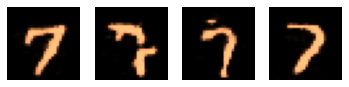

In [23]:
train (train_dataset, EPOCHS)

In [24]:
#
# D was used to train G and can now be discarded.
# 
# G is the result of training and the only model required when finished.  If you want to save G then:
#
# G.save ("your path here")
#
# Use the below to reload it in another notebook:
#
# G = keras.models.load_model("your path here")
#

In [25]:
Y_ = D.predict (targetIm)

 37/196 [====>.........................] - ETA: 0s

2023-12-20 15:29:27.738719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - 1s 4ms/step


In [26]:
sum (Y_ > 0) / total

array([0.61739824])

1/1 [==============================] - 0s 8ms/step


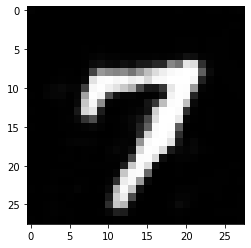

In [27]:

fakes = []

for i in range (20):
    
    noise = tf.random.normal([1, noiseVecDim])
    generated_image = G (noise, training=False)
    plt.imshow(generated_image[0, :, :, 0], cmap='gray')
    fakes.append (D.predict (generated_image))

In [28]:
fakes

[array([[-0.00291509]], dtype=float32),
 array([[-0.00291509]], dtype=float32),
 array([[-0.00291509]], dtype=float32),
 array([[-0.00291509]], dtype=float32),
 array([[-0.00291509]], dtype=float32),
 array([[-0.00291509]], dtype=float32),
 array([[-0.00291509]], dtype=float32),
 array([[-0.00291509]], dtype=float32),
 array([[-0.00291509]], dtype=float32),
 array([[-0.00291509]], dtype=float32),
 array([[-0.00291509]], dtype=float32),
 array([[-0.00291509]], dtype=float32),
 array([[-0.00291509]], dtype=float32),
 array([[-0.00291509]], dtype=float32),
 array([[-0.00291509]], dtype=float32),
 array([[-0.00291509]], dtype=float32),
 array([[-0.00291509]], dtype=float32),
 array([[-0.00291509]], dtype=float32),
 array([[-0.00291509]], dtype=float32),
 array([[-0.00291509]], dtype=float32)]